# Direct sampling with Gaussian process regression

#### Import general modules

mpi4py is always required when using these tools. Numpy is always good to have if any manipulation is to be done.

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

import os
os.environ["PYSEMTOOLS_DEBUG"] = 'false'
os.environ["PYSEMTOOLS_HIDE_LOG"] = 'false'

#### Import modules from pysemtools

In this case we will import all the data types that we currently support, as well as io functions that are required to populate them.

In [2]:
# Data types
from pysemtools.datatypes.msh import Mesh
from pysemtools.datatypes.coef import Coef
from pysemtools.datatypes.field import Field, FieldRegistry

# Readers
from pysemtools.io.ppymech.neksuite import preadnek, pynekread

# Writers
from pysemtools.io.ppymech.neksuite import pwritenek, pynekwrite

fname = '../data/mixlay0.f00001'

## Read the data

In [3]:
# Read the data
msh = Mesh(comm, create_connectivity=False)
fld = FieldRegistry(comm)
pynekread(fname, comm, data_dtype=np.double, msh = msh, fld = fld)
 
# Get the coefficients
coef = Coef(msh=msh, comm=comm)

2025-02-28 01:25:18,299 - Mesh - INFO - Initializing empty Mesh object.
2025-02-28 01:25:18,300 - Field - INFO - Initializing empty Field object
2025-02-28 01:25:18,301 - pynekread - INFO - Reading file: ../data/mixlay0.f00001
2025-02-28 01:25:18,308 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-02-28 01:25:18,308 - Mesh - INFO - Initializing common attributes.
2025-02-28 01:25:18,309 - Mesh - INFO - Getting vertices
2025-02-28 01:25:18,310 - Mesh - INFO - Getting edge centers
2025-02-28 01:25:18,316 - Mesh - INFO - Facet centers not available for 2D
2025-02-28 01:25:18,317 - Mesh - INFO - Mesh object initialized.
2025-02-28 01:25:18,317 - Mesh - INFO - Mesh data is of type: float64
2025-02-28 01:25:18,318 - Mesh - INFO - Elapsed time: 0.010231129000000002s
2025-02-28 01:25:18,318 - pynekread - INFO - Reading field data
2025-02-28 01:25:18,324 - pynekread - INFO - File read
2025-02-28 01:25:18,325 - pynekread - INFO - Elapsed time: 0.023663929s
2025-02-28 01:25:18,

## Compress the data with GPR

### Method 2

A method that is, perhaps, more effective than the previous one (example 1), is to somehow extend the capabilities of DLT, by using gaussian process regression to create a good error estimator that can be used to adaptively sample more in regions with high uncertainty.

In this case, the procedure is to keep the number of samples low, but instead refine the accuracy of the approximation of the covariance. We will see how appropiate it is.

### Initialize the Direct s

For this case, we use the torch bckend. This one has more support for the DLT procedures.

In [4]:
from pysemtools.compression.gpc_direct_sampling import DirectSampler

# Initialize a sampler with numpy (default)
ds = DirectSampler(comm=comm, msh=msh, bckend="torch")

2025-02-28 01:25:18,381 - DirectSampler - INFO - Initializing the DirectSampler from a Mesh object


### Sample the data

Sample the data using avergaes to determine the covariance

In [5]:
# Select the options
n_samples = 2
bitrate = n_samples/(msh.lx*msh.ly*msh.lz)
ds.log.tic()
ds.sample_field(field=fld.registry["u"], field_name="u", covariance_method="dlt", covariance_keep_modes=8, compression_method="fixed_bitrate", bitrate = bitrate)
ds.log.toc()

2025-02-28 01:25:18,395 - DirectSampler - INFO - Sampling the field with options: covariance_method: {covariance_method}, compression_method: {compression_method}
2025-02-28 01:25:18,397 - DirectSampler - INFO - Estimating the covariance matrix
2025-02-28 01:25:18,398 - DirectSampler - INFO - Transforming the field into to legendre space
2025-02-28 01:25:18,400 - DirectSampler - INFO - Estimating the covariance matrix using the SVD method. Keeping 8 modes
2025-02-28 01:25:18,407 - DirectSampler - INFO - f_hat saved in field uncompressed_data["u"]["f_hat"]
2025-02-28 01:25:18,408 - DirectSampler - INFO - Covariance matrix estimated with settings: {'method': 'dlt', 'averages': np.int64(1600), 'elements_to_average': 1, 'keep_modes': 8, 'kw_diag': False}
2025-02-28 01:25:18,409 - DirectSampler - INFO - Sampling the field using the fixed bitrate method. using settings: {'method': 'fixed_bitrate', 'bitrate': np.float64(0.03125), 'n_samples': 2}
2025-02-28 01:25:18,409 - DirectSampler - INFO 

### Write out and visualize the uncertainty

To write the uncertainty, it is best to do it before encoding. It is at this time that the original data is available. Correctly determining the uncertianty after this might be more problematic unless a good model of the covariances is present

In [6]:
fld_out = FieldRegistry(comm)

# Get estimated of uncertainty for the velocity and its derivatives
_, u_std_d = ds.reconstruct_field(field_name = "u", get_std = True, unsampled_field_available=True)
_, dudr_std_d = ds.reconstruct_field(field_name = "u", get_std = True, unsampled_field_available=True, std_op=ds.dr_d)
_, duds_std_d = ds.reconstruct_field(field_name = "u", get_std = True, unsampled_field_available=True, std_op=ds.ds_d)


dudx_std = dudr_std_d.cpu().numpy()*coef.drdx + duds_std_d.cpu().numpy()*coef.dsdx
dudy_std = dudr_std_d.cpu().numpy()*coef.drdy + duds_std_d.cpu().numpy()*coef.dsdy

fld_out.add_field(comm, field_name="u_std", field=u_std_d.cpu().numpy(), dtype=np.single)
fld_out.add_field(comm, field_name="dudx_std", field=dudx_std, dtype=np.single)
fld_out.add_field(comm, field_name="dudy_std", field=dudy_std, dtype=np.single)
pynekwrite("u_std_dlt0.f00001", comm, msh = msh, fld = fld_out)

2025-02-28 01:25:18,763 - Field - INFO - Initializing empty Field object
2025-02-28 01:25:18,803 - DirectSampler - INFO - Processing up to 256/1600 elements
2025-02-28 01:25:18,816 - DirectSampler - INFO - Processing up to 512/1600 elements
2025-02-28 01:25:18,826 - DirectSampler - INFO - Processing up to 768/1600 elements
2025-02-28 01:25:18,838 - DirectSampler - INFO - Processing up to 1024/1600 elements
2025-02-28 01:25:18,847 - DirectSampler - INFO - Processing up to 1280/1600 elements
2025-02-28 01:25:18,861 - DirectSampler - INFO - Processing up to 1536/1600 elements
2025-02-28 01:25:18,871 - DirectSampler - INFO - Processing up to 1600/1600 elements
2025-02-28 01:25:18,915 - DirectSampler - INFO - Processing up to 256/1600 elements
2025-02-28 01:25:18,935 - DirectSampler - INFO - Processing up to 512/1600 elements
2025-02-28 01:25:18,954 - DirectSampler - INFO - Processing up to 768/1600 elements
2025-02-28 01:25:18,974 - DirectSampler - INFO - Processing up to 1024/1600 element

### Visualize it!

Since this is a 2D field, we can easily visualize it in python, but for this case, we show how it looks in visit:

The uncertainty of the velocity is the following:
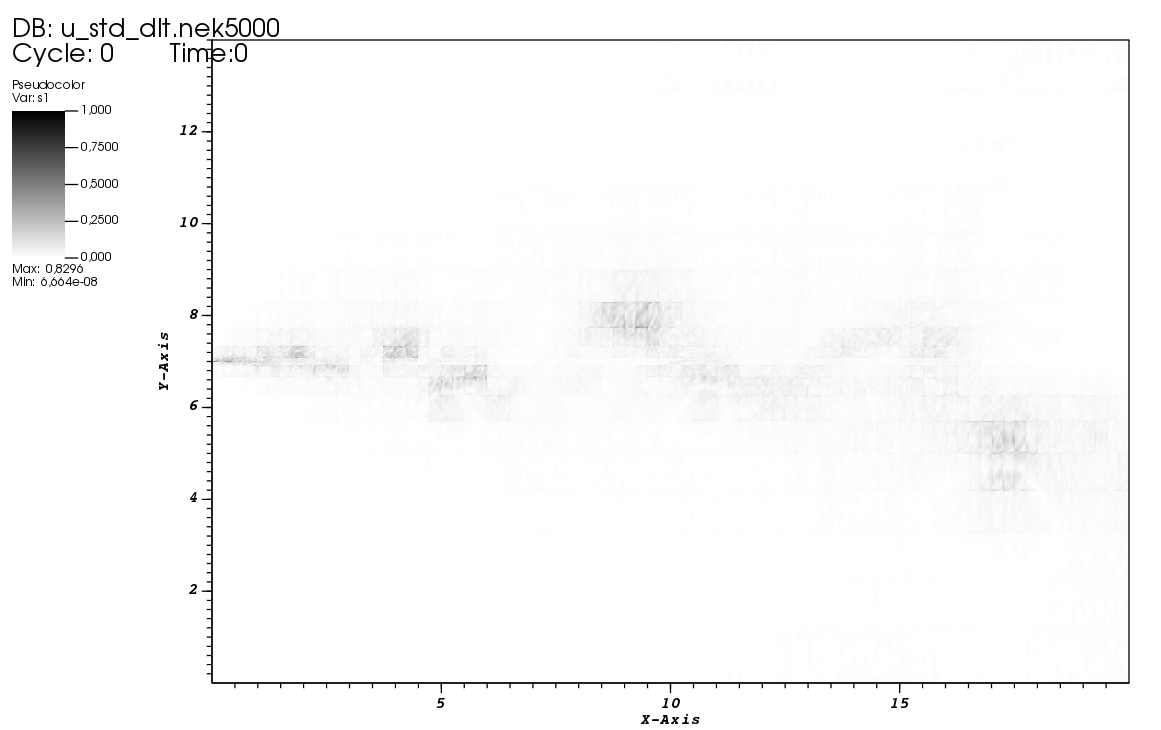

The uncertainty on its derivatives looks as follows:
dudx:
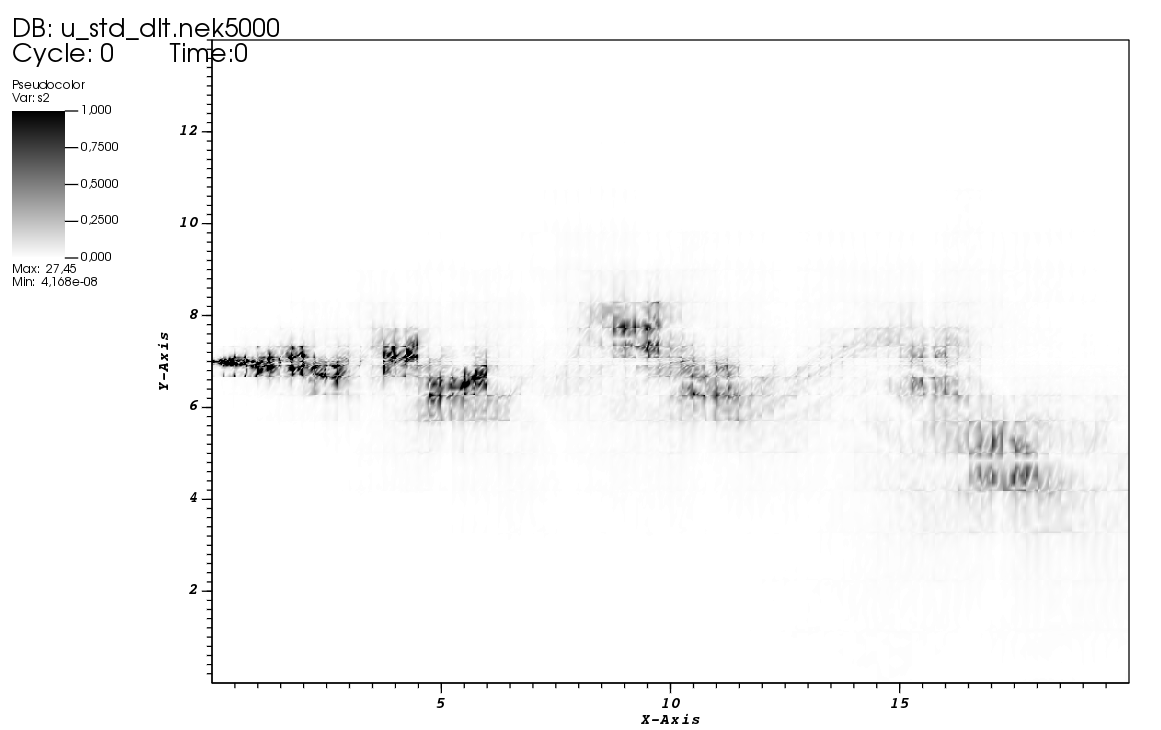

dudy:
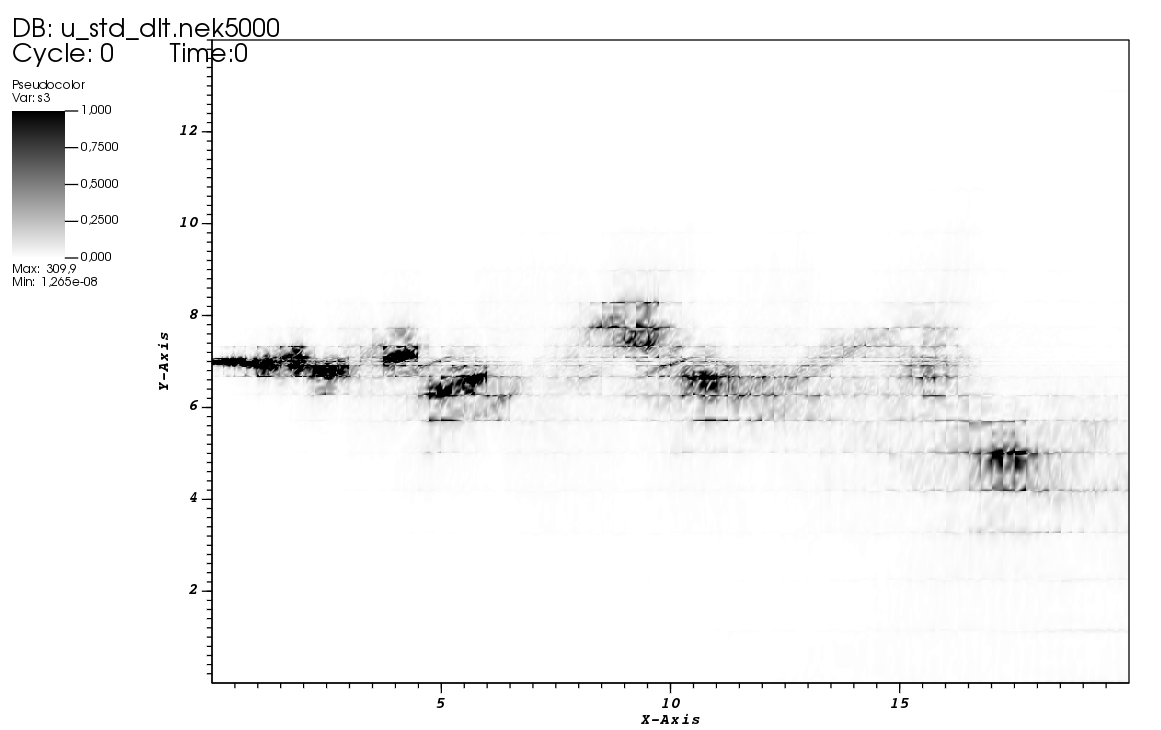

Note that the uncertainty depends on the approximation of the covariance. Note that there is more uncertainty on the derivatives. This is normal, since we are cutting the legendre coefficients quite abruptly. We can reduce it by increasing our knowledge of the covariance (increasing the coefficients we retain). Also note that the uncertainty is not the same everywhere, therefore one can do the truncation selectively.

### Encode it

The data that needs to be compressed for this method is stored in the directory ds.uncompressed_data. We can now encode it with bzip2

In [7]:
ds.compress_samples(lossless_compressor="bzip2")

2025-02-28 01:25:19,233 - DirectSampler - INFO - Compressing the data using the lossless compressor: bzip2
2025-02-28 01:25:19,234 - DirectSampler - INFO - Compressing data in uncompressed_data
2025-02-28 01:25:19,235 - DirectSampler - INFO - Compressing data for field ["u"]:
2025-02-28 01:25:19,236 - DirectSampler - INFO - Compressing ["f_hat"] for field ["u"]
2025-02-28 01:25:19,255 - DirectSampler - INFO - Compressing ["field"] for field ["u"]


### Write it out

Write out the compressed file

In [8]:
ds.write_compressed_samples(comm=comm, filename="test_ds_dlt")

2025-02-28 01:25:19,412 - DirectSampler - INFO - Parallel HDF5 not available; creating folder to store rank files.


## Decompress the data

Just to show, let's see how the uncompression process works.

### Read the data

First we must read the data. In this process, it will be first read as a bzip compressed byte object. At this step it will be unencoded but still not be a cfd field.

In [9]:
ds_read = DirectSampler(comm, filename="test", bckend="torch")

2025-02-28 01:25:19,426 - DirectSampler - INFO - Initializing the DirectSampler from file: test


### Reconstruct the data from the samples

In [10]:
u_d, u_std_d = ds_read.reconstruct_field(field_name="u", get_mean=True, get_std=True)

2025-02-28 01:25:19,500 - DirectSampler - INFO - Processing up to 256/1600 elements
2025-02-28 01:25:19,519 - DirectSampler - INFO - Processing up to 512/1600 elements
2025-02-28 01:25:19,533 - DirectSampler - INFO - Processing up to 768/1600 elements
2025-02-28 01:25:19,552 - DirectSampler - INFO - Processing up to 1024/1600 elements
2025-02-28 01:25:19,566 - DirectSampler - INFO - Processing up to 1280/1600 elements
2025-02-28 01:25:19,584 - DirectSampler - INFO - Processing up to 1536/1600 elements
2025-02-28 01:25:19,598 - DirectSampler - INFO - Processing up to 1600/1600 elements


## Visualize the data

In [11]:
# General settings

u = fld.registry["u"]
u_levels = np.linspace(np.min(u), np.max(u), 100)
err_levels = np.linspace(0, 0.001, 100)

### See the data and the errors.

Keep in mind that the uncertainty shown here is not super accurate, given that at this stage, we have already discarded the original data. If you want to keep the uncertainty exactly, write it a compression time.

1


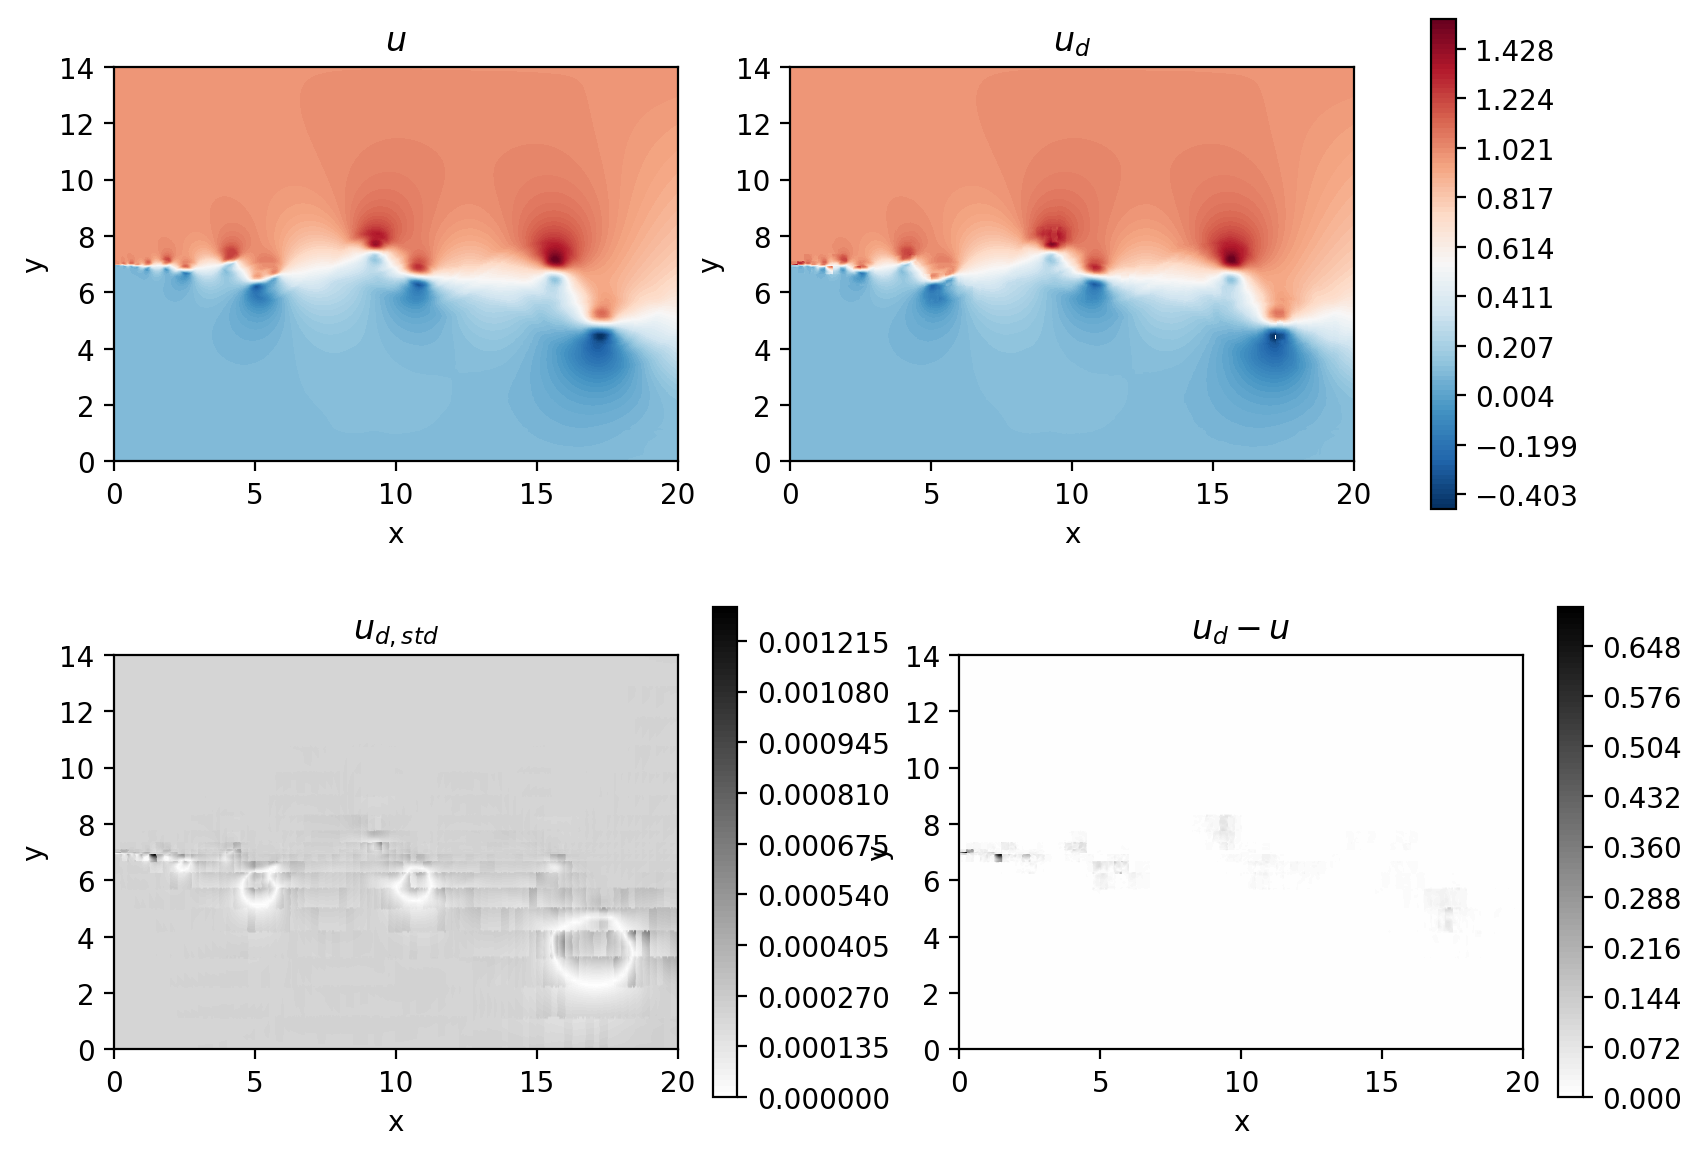

In [12]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 7), dpi = 200)

c00 = ax[0,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,fld.registry["u"].flatten(), levels=u_levels, cmap="RdBu_r")
ax[0,0].set_aspect('equal')
ax[0,0].set_xlabel("x")
ax[0,0].set_ylabel("y")
ax[0,0].set_title(r"$u$")

c01 = ax[0,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,u_d.cpu().numpy().flatten(), levels=u_levels, cmap="RdBu_r")
ax[0,1].set_aspect('equal')
ax[0,1].set_xlabel("x")
ax[0,1].set_ylabel("y")
ax[0,1].set_title(r"$u_{d}$")

scaling = 1/np.max(u_std_d.cpu().numpy().flatten())*0.54
scaling = 1
print(scaling)
#c10 = ax[1,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,u_std_d.cpu().numpy().flatten(), levels=np.linspace(0,0.5, 100), cmap="gray_r")
c10 = ax[1,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,u_std_d.cpu().numpy().flatten()*scaling, levels=100, cmap="gray_r")
ax[1,0].set_aspect('equal')
ax[1,0].set_xlabel("x")
ax[1,0].set_ylabel("y")
ax[1,0].set_title(r"$u_{d,std}$")

c11 = ax[1,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,np.sqrt((u_d.cpu().numpy().flatten()- u.flatten())**2), levels=100, cmap="gray_r")
ax[1,1].set_aspect('equal')
ax[1,1].set_xlabel("x")
ax[1,1].set_ylabel("y")
ax[1,1].set_title(r"$u_{d} - u$")

cbar0=fig.colorbar(c00, ax=ax[0,:])
cbar10=fig.colorbar(c10, ax=ax[1,0])
cbar11=fig.colorbar(c11, ax=ax[1,1])
plt.show()

See that the uncertainty is off now. This happens because at this stage, we use our model of the covariance function to find all the required matrices in GPR. At compression time we have more knowledge about the data.

It is still usefull to observe were the data is more uncertain, but we can not be so sure about the magnitud at this stage.

## Test the derivative

Just for completion, check if the derivatives look okay

In [13]:
# Initiate the mesh partitioning
from pysemtools.datatypes.msh_connectivity import MeshConnectivity

msh_conn = MeshConnectivity(comm, msh = msh, use_hashtable=True)

dudx = coef.dudxyz(u, coef.drdx, coef.dsdx)
dudy = coef.dudxyz(u, coef.drdy, coef.dsdy)

dudx_d = coef.dudxyz(u_d.cpu().numpy(), coef.drdx, coef.dsdx)
dudy_d = coef.dudxyz(u_d.cpu().numpy(), coef.drdy, coef.dsdy)

dudx_levels = np.linspace(-2.5, 3.1, 100)
dudy_levels = np.linspace(-4.6, 7.6, 100)

2025-02-28 01:25:25,309 - MeshConnectivity - INFO - Initializing MeshConnectivity
2025-02-28 01:25:25,310 - MeshConnectivity - INFO - Computing local connectivity
2025-02-28 01:25:25,376 - MeshConnectivity - INFO - Computing global connectivity
2025-02-28 01:25:25,378 - MeshConnectivity - INFO - Computing multiplicity
2025-02-28 01:25:25,395 - MeshConnectivity - INFO - MeshConnectivity initialized
2025-02-28 01:25:25,396 - MeshConnectivity - INFO - Elapsed time: 0.08605008500000011s
2025-02-28 01:25:25,397 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-02-28 01:25:25,403 - Coef - INFO - done
2025-02-28 01:25:25,404 - Coef - INFO - Elapsed time: 0.00674975400000033s
2025-02-28 01:25:25,404 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-02-28 01:25:25,413 - Coef - INFO - done
2025-02-28 01:25:25,413 - Coef - INFO - Elapsed time: 0.00842882599999939s
2025-02-28 01:25:25,414 - Coef - INFO - Calculating the derivati

### Visualize

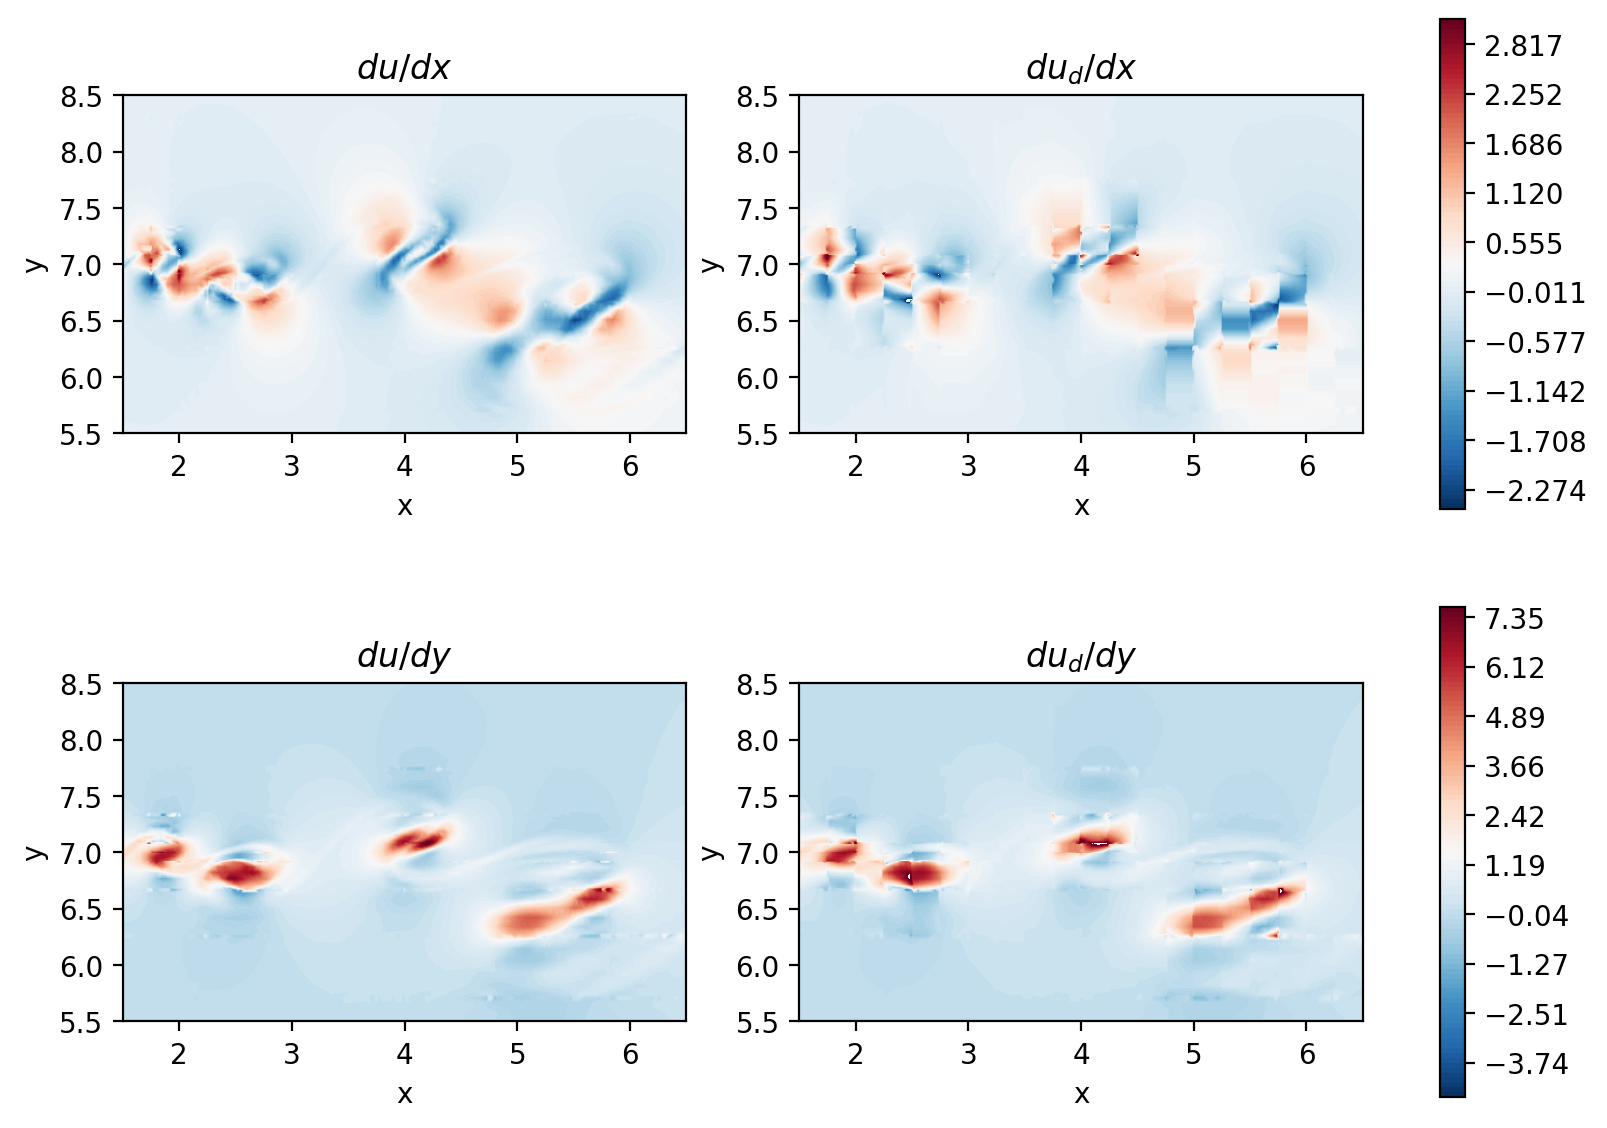

In [14]:

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 7), dpi = 200)

c00 = ax[0,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudx.flatten(), levels=dudx_levels, cmap="RdBu_r")
ax[0,0].set_aspect('equal')
ax[0,0].set_xlabel("x")
ax[0,0].set_ylabel("y")
ax[0,0].set_title(r"$du/dx$")

c01 = ax[0,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudx_d.flatten(), levels=dudx_levels, cmap="RdBu_r")
ax[0,1].set_aspect('equal')
ax[0,1].set_xlabel("x")
ax[0,1].set_ylabel("y")
ax[0,1].set_title(r"$du_{d}/dx$")

c10 = ax[1,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudy.flatten(), levels=dudy_levels, cmap="RdBu_r")
ax[1,0].set_aspect('equal')
ax[1,0].set_xlabel("x")
ax[1,0].set_ylabel("y")
ax[1,0].set_title(r"$du/dy$")

c11 = ax[1,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudy_d.flatten(), levels=dudy_levels, cmap="RdBu_r")
ax[1,1].set_aspect('equal')
ax[1,1].set_xlabel("x")
ax[1,1].set_ylabel("y")
ax[1,1].set_title(r"$du_{d}/dy$")

cbar0=fig.colorbar(c00, ax=ax[0,:])
cbar10=fig.colorbar(c10, ax=ax[1,:])


ax[0,0].set_xlim([1.5,6.5])
ax[0,0].set_ylim([5.5,8.5])

ax[0,1].set_xlim([1.5,6.5])
ax[0,1].set_ylim([5.5,8.5])

ax[1,0].set_xlim([1.5,6.5])
ax[1,0].set_ylim([5.5,8.5])

ax[1,1].set_xlim([1.5,6.5])
ax[1,1].set_ylim([5.5,8.5])

plt.show()

Once again, while the velocity looked fine, the derivative is not so good! But we knew! since we had calculated large uncertainty. Just for completion, we show those plots agian:

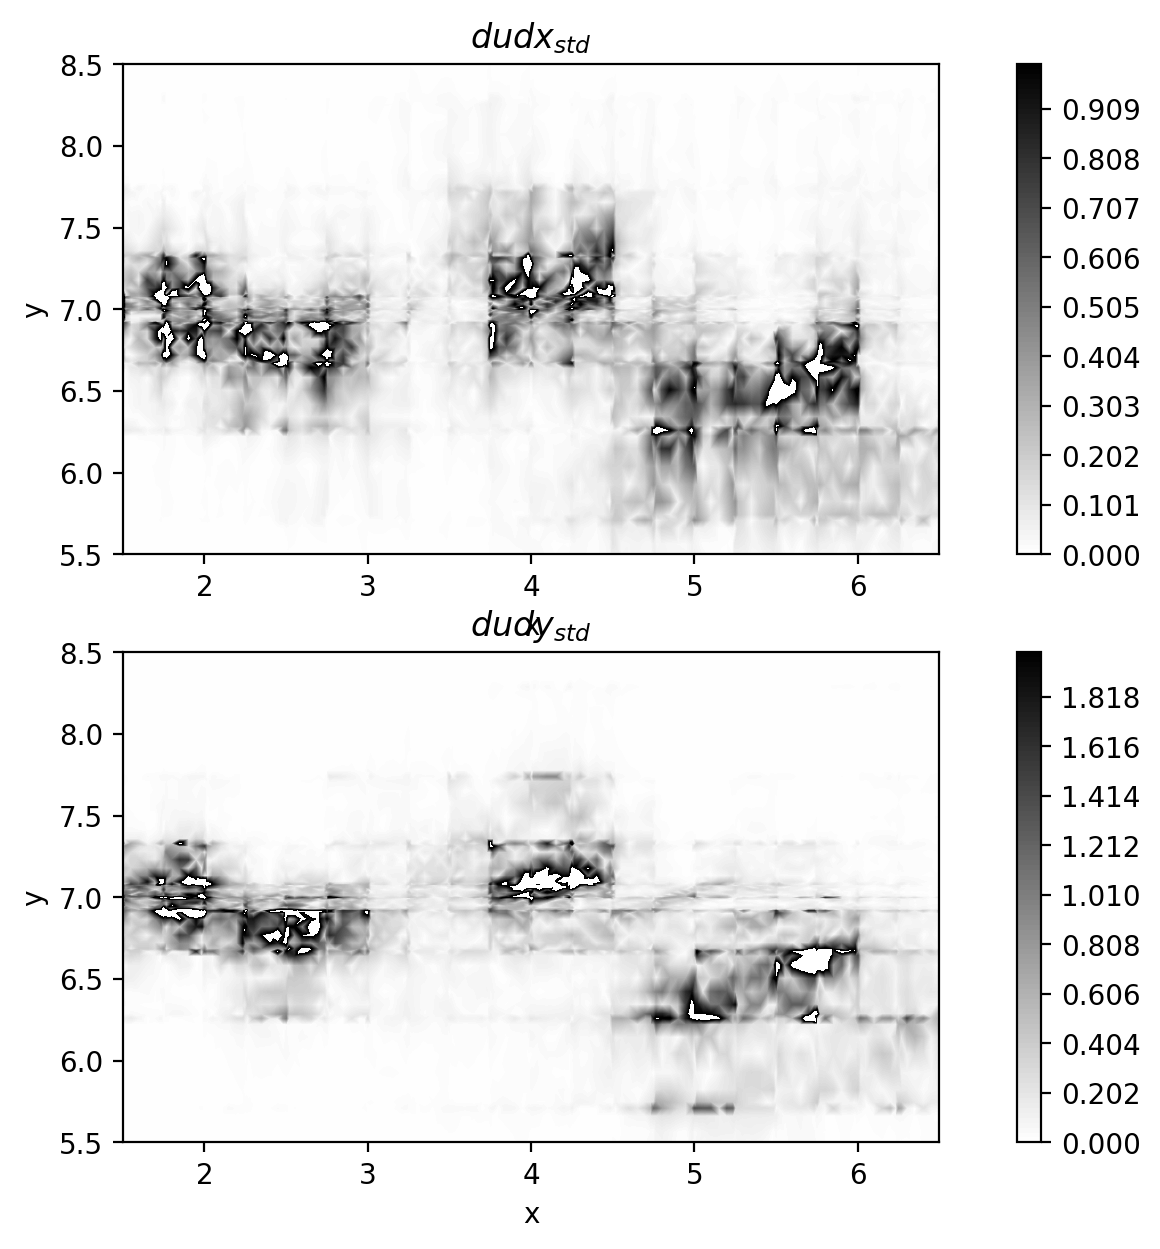

In [15]:

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10, 7), dpi = 200)

c00 = ax[0].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudx_std.flatten(), levels=np.linspace(0,1,100), cmap="gray_r")
ax[0].set_aspect('equal')
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title(r"$dudx_{std}$")


c11 = ax[1].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudy_std.flatten(), levels=np.linspace(0,2,100), cmap="gray_r")
ax[1].set_aspect('equal')
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title(r"$dudy_{std}$")

cbar0=fig.colorbar(c00, ax=ax[0])
cbar11=fig.colorbar(c11, ax=ax[1])

ax[0].set_xlim([1.5,6.5])
ax[0].set_ylim([5.5,8.5])

ax[1].set_xlim([1.5,6.5])
ax[1].set_ylim([5.5,8.5])

plt.show()